##### This assignment is consists of two parts, i.e., Part 1: Classification with Deep Neural Networks & Part 2: Adversarial Examples for Neural Networks.

## Part 1: Classification Task with Deep Neural Networks

In this part, you will implement two neural networks (one neural network and one convolution neural network) using PyTorch to classify images of Fashion MNIST dataset (https://research.zalando.com/project/fashion_mnist/fashion_mnist/). Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset (http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms.


First, we need to import some useful libraries. If your computer have not install the pytorch, you are encouraged to finish the first part of the program via Colab (https://research.google.com/colaboratory/). 

In [50]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import random
import numpy as np
import matplotlib.pyplot as plt

Please first finish the following simple task to review some useful functions in classification:

(a) **[5 points]** Please realize an util function: <em>one_hot_labels</em>.

In the implementation of the cross entropy loss, it is much convenient if numerical labels are transformed into one-hot labels. For example, numerical label 5 -> one-hot label [0,0,0,0,0,1,0,0,0,0]. Accordingly, the cross entropy loss can be written as follow:

$CE(y,\hat y)=-\sum_{k=1}^K y_k \log \hat y_k$,

where $\hat y$ is the softmax outputs from the model for the training example, $y$ is the one-hot (ground-truth) label, and the subscript refers to the element of $y$ at the coordinate $k$. 

(b) **[5 points]** Please realize the softmax function as well as the sigmoid function: <em>softmax(x)</em> and <em>sigmoid(x)</em>.

The $k$-th element of softmax is calculated via:

$softmax(x)_k=\frac {e^{x_k}}{\sum_j e^{x_j}}=\frac {e^{x_k+c}}{\sum_j e^{x_j+c}}$

The last equation holds since adding a constant won't change softmax results. Note that, you may encounter an overflow when softmax computes the exponential, so please using the 'max' tricks to avoid this problem.  

The sigmoid is calculated by:

$sigmoid(x)=\frac {1}{1+e^{-x}} = \frac {e^x}{e^x + 1}$

For numerical stability, please use the 1st equation for positive inputs, and the 2nd equation for negative inputs. 

In [51]:
def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    
    ### YOUR CODE HERE
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    ### END YOUR CODE
    return one_hot_labels

def softmax(x):
    """
    x is of shape: batch_size * #class
    """
    ### YOUR CODE HERE
    c = np.max(x, axis=1, keepdims=True)
    numerator = np.exp(x - c)
    denominator = np.sum(numerator, axis=1, keepdims=True)
    s = numerator / denominator
    ### END YOUR CODE
    return s

def sigmoid(x):
    """
    x is of shape: batch_size * dim_hidden
    """
    ### YOUR CODE HERE
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    
    z = np.zeros_like(x, dtype=float)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    
    top = np.ones_like(x, dtype=float)
    top[neg_mask] = z[neg_mask]
    s = top / (1 + z)
    ### END YOUR CODE
    return s

Now, let's begin the classification task after you get some initial idea about the loss functions defined before.

(c) **[5 points]** Please load the Fashion-MNIST by the datasets provided by torchvision. (https://pytorch.org/vision/stable/datasets.html)

If you have not downloaded the FashionMNIST dataset, you can download it by setting appropriate parameters. As for the transform, you may feel free to chose transforms for your training data.

In [52]:
#!pip install -U d2l

In [53]:
### YOUR CODE HERE
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)   
### END YOUR CODE

train_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

(d) **[10 points]** Please define** the first model class** (DeepNeuralNetwork: a simple neural network) as follows, the DeepNeuralNetwork should match both the input dimention for the images and output dimention for classification task. It is recommended that the model include (linear layer, relu layer, linear layer, relu layer, linear layer)-liked structure for the task (you are also encouraged to choose any advanced structure settings to achieve higher task accuracy), and you also need to define the corresponding forward function for this task.

In [54]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        ### END CODE HERE

    def forward(self, x):
        ### YOUR CODE HERE
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

        ### END CODE HERE

(e) **[12 points]** Please define **the second model class** (ConvNeuralNetwork: a simple convolution neural network) as follows, the ConvNeuralNetwork should also match both the input dimention for the images and output dimention for classification task. It is recommended that the model include two convolution layers (each layer should contain nn.Conv2d, nn.ReLU and nn.MaxPool2d https://pytorch.org/docs/stable/nn.html#convolution-layers )-liked structure for the task (you are also encouraged to choose any advanced structure settings to achieve higher task accuracy), and you also need to define the corresponding forward function for this task.

In [55]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        ### YOUR CODE HERE
        super(ConvNeuralNetwork, self).__init__()
        # The first Conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,6,kernel_size=5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 ,stride = 2,padding=0)
        )
        # The second Conv
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,kernel_size=5,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2 ,stride = 2,padding=0)            
        )
        # The output layer
        self.fc1 = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84,10)        
        

        ### END CODE HERE

    def forward(self, x):
        ### YOUR CODE HERE
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)    
        return x
        ### END CODE HERE

(f) **[3 points]** Please define the learning_rate, batch_size, training_epochs (5) and loss_function (nn.CrossEntropyLoss) using torch.nn. You may feel free to choose the training parameters but please try your best to find a better parameter which can well train your defined model.

In [56]:
### YOUR CODE HERE
learning_rate = 1e-3 #(I will compare two leraning rate; 1e-3 and 2e-1) )
batch_size =512
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
### END CODE HERE

(g) **[5 points]** Please finish the training function which uses the previous defined model, loss function and optimizer. 

In [57]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    ### YOUR CODE HERE
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ### END CODE HERE
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


(h) **[5 points]** Please finish the test function which uses the previous defined model and loss function. In the test function, you need to calculate the test accuracy for each epoch,

In [58]:
def test_loop(dataloader, model, loss_fn):
    ### YOUR CODE HERE
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    ### END CODE HERE
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

(i) **[5 points]** Please try the first deep neural network that defined before using the training and test functions.

In [59]:
#model = DeepNeuralNetwork()
#lr = 1e-3
model = NeuralNetwork()
epochs = 5

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### YOUR CODE HERE
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

### END CODE HERE
print("Done!")

Epoch 1
-------------------------------
loss: 2.301959  [    0/60000]
loss: 2.280067  [12800/60000]
loss: 2.269731  [25600/60000]
loss: 2.260156  [38400/60000]
loss: 2.237974  [51200/60000]
Test Error: 
 Accuracy: 19.3%, Avg loss: 2.228125 

Epoch 2
-------------------------------
loss: 2.232590  [    0/60000]
loss: 2.203154  [12800/60000]
loss: 2.194361  [25600/60000]
loss: 2.186452  [38400/60000]
loss: 2.156604  [51200/60000]
Test Error: 
 Accuracy: 41.9%, Avg loss: 2.143525 

Epoch 3
-------------------------------
loss: 2.146974  [    0/60000]
loss: 2.105623  [12800/60000]
loss: 2.094529  [25600/60000]
loss: 2.081418  [38400/60000]
loss: 2.043523  [51200/60000]
Test Error: 
 Accuracy: 56.8%, Avg loss: 2.023018 

Epoch 4
-------------------------------
loss: 2.022669  [    0/60000]
loss: 1.965381  [12800/60000]
loss: 1.949336  [25600/60000]
loss: 1.924864  [38400/60000]
loss: 1.883783  [51200/60000]
Test Error: 
 Accuracy: 61.0%, Avg loss: 1.853031 

Epoch 5
------------------------

In [60]:
#learning_rate =2e-1
model = NeuralNetwork()
epochs = 5

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=2e-1)

### YOUR CODE HERE
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

### END CODE HERE
print("Done!")

Epoch 1
-------------------------------
loss: 2.305113  [    0/60000]
loss: 0.595381  [12800/60000]
loss: 0.535711  [25600/60000]
loss: 0.463916  [38400/60000]
loss: 0.619123  [51200/60000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.471545 

Epoch 2
-------------------------------
loss: 0.344490  [    0/60000]
loss: 0.434144  [12800/60000]
loss: 0.365777  [25600/60000]
loss: 0.373672  [38400/60000]
loss: 0.500140  [51200/60000]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.438777 

Epoch 3
-------------------------------
loss: 0.304787  [    0/60000]
loss: 0.365933  [12800/60000]
loss: 0.319774  [25600/60000]
loss: 0.334838  [38400/60000]
loss: 0.443920  [51200/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.408814 

Epoch 4
-------------------------------
loss: 0.271616  [    0/60000]
loss: 0.325942  [12800/60000]
loss: 0.296693  [25600/60000]
loss: 0.306548  [38400/60000]
loss: 0.416288  [51200/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.384554 

Epoch 5
------------------------

so learning rate = 2e-1 has higher accuracy.

(j) **[5 points]** Please try the second deep neural network that defined before using the training and test functions.

In [61]:
#learning rate = 1e-3
model = ConvNeuralNetwork()
epochs = 5

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
### YOUR CODE HERE
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

### END CODE HERE
print("Done!")

Epoch 1
-------------------------------
loss: 2.306318  [    0/60000]
loss: 2.300606  [12800/60000]
loss: 2.300470  [25600/60000]
loss: 2.306922  [38400/60000]
loss: 2.293545  [51200/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.298968 

Epoch 2
-------------------------------
loss: 2.301943  [    0/60000]
loss: 2.296512  [12800/60000]
loss: 2.295878  [25600/60000]
loss: 2.302437  [38400/60000]
loss: 2.289320  [51200/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.294353 

Epoch 3
-------------------------------
loss: 2.297395  [    0/60000]
loss: 2.291750  [12800/60000]
loss: 2.290508  [25600/60000]
loss: 2.297690  [38400/60000]
loss: 2.283702  [51200/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.288509 

Epoch 4
-------------------------------
loss: 2.291754  [    0/60000]
loss: 2.285229  [12800/60000]
loss: 2.283320  [25600/60000]
loss: 2.291492  [38400/60000]
loss: 2.275774  [51200/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.280158 

Epoch 5
------------------------

In [62]:
#learning rate = 2e-1
model = ConvNeuralNetwork()
epochs = 5

# Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=2e-1)
### YOUR CODE HERE
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

### END CODE HERE
print("Done!")

Epoch 1
-------------------------------
loss: 2.306721  [    0/60000]
loss: 1.755281  [12800/60000]
loss: 0.793896  [25600/60000]
loss: 0.545092  [38400/60000]
loss: 0.554672  [51200/60000]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.509154 

Epoch 2
-------------------------------
loss: 0.411477  [    0/60000]
loss: 0.399081  [12800/60000]
loss: 0.394338  [25600/60000]
loss: 0.421502  [38400/60000]
loss: 0.489950  [51200/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.423665 

Epoch 3
-------------------------------
loss: 0.297231  [    0/60000]
loss: 0.354954  [12800/60000]
loss: 0.330187  [25600/60000]
loss: 0.364467  [38400/60000]
loss: 0.452863  [51200/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.379614 

Epoch 4
-------------------------------
loss: 0.240598  [    0/60000]
loss: 0.325760  [12800/60000]
loss: 0.285345  [25600/60000]
loss: 0.340598  [38400/60000]
loss: 0.414508  [51200/60000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.351869 

Epoch 5
------------------------

So in general learning rate = 2e-1 has higher accuracy and less avg loss

## Part 2: Adversarial Examples for Neural Networks

It has been seen that many classifiers, including neural networks, are highly susceptible to what are called adversarial examples -- small perturbations of the input that cause a classifier to misclassify, but are imperceptible to humans. For example, making a small change to an image of a stop sign might cause an object detector in an autonomous vehicle to classify it as an yield sign, which could lead to an accident.

In this part, we will see **how to construct adversarial examples for neural networks**, and you are given a 3-hidden layer perceptron trained on the MNIST dataset for this purpose.

Since we are interested in constructing the countersample rather than the original classification task, we do not need to worry too much about the design of the neural network and the processing of the data (which are already given). The parameters of the perceptron can be loaded from fc\*.weight,npy and fc\*.bias.npy. The test dataset can be loaded from X_test.npy and Y_test.npy. Each image of MNIST is 28×28 pixels in size, and is generally represented as a flat vector of 784 numbers. It also includes labels for each example, a number indicating the actual digit (0 - 9) handwritten in that image. 

**Enjoy practicing generating adversarial examples and have fun!**




In [81]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

First, we need to define some functions for later computing.

(a) **[5 points]** Please realize the following functions: 

relu: The relu function is calculated as:

$$
relu(x)=max(0,x)
$$

relu_grad: The relu_grad is used to compute the gradient of relu function as:

$$
relu\_grad(x)=(1(x>0),0(x \leq 0))
$$

one_hot: In the implementation of the cross entropy loss, it is much convenient if numerical labels are transformed into one-hot labels. For example, numerical label 6 -> one-hot label [0,0,0,0,0,0,1,0,0,0]. Accordingly, the cross entropy loss can be written as follow:

$$
cross\_entropy(y,\hat y)=-\sum_{k=1}^K y_k \log \hat y_k
$$

where $\hat{y}$ is the softmax outputs from the model for the training example, $y$ is the one-hot (ground-truth) label, and the subscript refers to the element of $y$ at the coordinate $k$. 


In [82]:
def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        relu_x: a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    ### YOUR CODE HERE
    relu_x = np.maximum(x, 0)
    ### END YOUR CODE
    return relu_x

def relu_grad(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        relu_grad_x: a vector in ndarray format,
        representing the gradient of ReLu activation.
    '''
    ### YOUR CODE HERE
     
    x[x<=0] = 0
    x[x>0] = 1
    relu_grad_x = x
    
    ### END YOUR CODE
    return relu_grad_x

def cross_entropy(y, y_hat):
    '''
    Input
        y: an int representing the class label
        y_hat: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(y_hat.squeeze())
    return log_likelihood[y]



Next, we define the structure and some utility functions of our multi-layer perceptron.


The neural net is a fully-connected multi-layer perceptron with three hidden layers. The hidden layers contains 2048, 512 and 512 hidden nodes respectively. We use ReLU as the activation function at each hidden node. The last intermediate layer’s output is passed through a softmax function, and the loss is measured as the cross-entropy between the resulted probability vector and the true label.


    x: the input image vector with dimension 1x784.
    y: the true class label of x.
    zi: the value of the i-th intermediate layer before activation, with dimension 1x2048, 1x512, 1x512 and 1x10 for i = 1, 2, 3, 4.
    hi: the value of the i-th intermediate layer after activation, with dimension 1x2048, 1x512 and 1x512 for i = 1, 2, 3.
    p: the predicted class probability vector after the softmax function, with dimension 1x10.
    Wi: the weights between the (i - 1)-th and the i-th intermediate layer. For simplicity, we use h0 as an alias to x. Each Wi has dimension li_1 x li, where li is the number of nodes in the i-th layer. For example, W1 ha dimension 784x2048.
    bi: the bias between the (i - 1)-th and the i-th intermediate layer. The dimension is 1 x li.

(b) **[20 points]** Please realize the forward propogation and the gradient calculation:

**[10 points]** The forward propagation rules are as follows.
$$
z^i = h^{i-1} \cdot W^i + b^i, i = 1, 2, 3, 4.
$$

$$
h^i = ReLU(z^i), i = 1, 2, 3.
$$

$$
p = Softmax(z^4)
$$

**[10 points]** The gradient calculation rules are as follows.

Let L denote the cross entropy loss of an image-label pair (x, y). We are interested in the gradient of L w.r.t. x, and move x in the direction of (the sign of) the gradient to increase L. If L becomes large, the new image x_adv will likely be misclassified.

We use chain rule for gradient computation. Again, let h0 be the alias of x. We have:
$$
\frac{\delta L}{\delta x} =  \frac{\delta L}{\delta z^4} \frac{\delta z^4}{\delta h^3} \prod_{i=1}^{3} \{ \frac{\delta h^i}{\delta z^i} \frac{\delta z^i}{\delta h^{i-1}} \}
$$

The intermediate terms can be computed as follows.

$$
\frac{\delta L}{z^4} = p - one\_hot(y)
$$

$$
\frac{z^i}{h^{i-1}} = (W^i)^T
$$

$$
\frac{\delta h^i}{\delta z^i}=relu\_grad(z^i)
$$

(c) **[10 points]** Please generate the adversarial examples based on the gradient.

We begin with deriving a simple way of constructing an adversarial example around an input (x, y).
Supppose we denote our neural network by a function f: X $\rightarrow$ {0,...,9}.
Suppose we want to find a small perturbation $\Delta$ of x such that the neural network f assigns a label different from y to x+$\Delta$. To find such a $\Delta$, we want to increase the cross-entropy loss of the network f at (x, y); in other words, we want to take a small step $\Delta$ along which the cross-entropy loss increases, thus causing a misclassification. We can write this as a gradient ascent update, and to ensure that we only take a small step, we can just use the sign of each coordinate of the gradient. The final algorithm is this:

$$
x_{adv} = x + \epsilon \cdot sign (\nabla L(f(x), y))
$$

where L is the cross-entropy loss, and it is known as the **Fast Gradient Sign Method (FGSM)**. In this time, you are required to realize the multi-times FGSM, which is known to be **PGD** method. To be specific, for overall $n$ times, we will conduct: 

$$
x_{adv}^t = x + (\epsilon / n) \cdot sign (\nabla L(f(x_{adv}^{t-1}), y))
$$



In [83]:
class MultiLayerPerceptron():
    '''
    This class defines the multi-layer perceptron we will be using
    as the attack target.
    
    '''
    def __init__(self):
        self.eps = 0.1
    
    def load_params(self, params):
        '''
        This method loads the weights and biases of a trained model.
        '''
        self.W1 = params["fc1.weight"]
        self.b1 = params["fc1.bias"]
        self.W2 = params["fc2.weight"]
        self.b2 = params["fc2.bias"]
        self.W3 = params["fc3.weight"]
        self.b3 = params["fc3.bias"]
        self.W4 = params["fc4.weight"]
        self.b4 = params["fc4.bias"]
        
    def set_attack_budget(self, eps):
        '''
        This method sets the maximum L_infty norm of the adversarial
        perturbation.
        '''
        self.eps = eps
        
    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            self.p: a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2, W3, W4 = self.W1, self.W2, self.W3, self.W4
        b1, b2, b3, b4 = self.b1, self.b2, self.b3, self.b4
        
        self.z1 = np.matmul(x,W1)+b1
        #######################################
        ### YOUR CODE HERE
        if len(self.z1.shape) < 2:
            self.z1 = np.expand_dims(self.z1, axis=0)
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)+b2
        self.h2 = relu(self.z2)
        self.z3 = np.matmul(self.h2,W3)+b3
        self.h3 = relu(self.z3)
        self.z4 = np.matmul(self.h3,W4)+b4
        self.p = softmax(self.z4)
        
        ### END YOUR CODE
        #######################################

        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)


    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            grad: a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        
        #######################################
        ### YOUR CODE HERE
         ### YOUR CODE HERE
        L = cross_entropy(y, self.forward(x))

        delta_L_z4 = self.forward(x)-one_hot_labels(y)
        delta_z4_h3 = self.W4.T
        delta_h3_z3 = relu_grad(self.z3)
        delta_z3_h2 = self.W3.T
        delta_h2_z2 = relu_grad(self.z2)
        delta_z2_h1 = self.W2.T
        delta_h1_z1 = relu_grad(self.z1)
        delta_z1_h0 = self.W1.T
        inter1 = np.dot(delta_L_z4, delta_z4_h3)
        inter2 = np.multiply(inter1, delta_h3_z3)
        inter3 = np.dot(inter2, delta_z3_h2)
        inter4 = np.multiply(inter3, delta_h2_z2)
        inter5 = np.dot(inter4, delta_z2_h1)
        inter6 = np.multiply(inter5, delta_h1_z1)
        inter7 = np.dot(inter6, delta_z1_h0)
        grad = inter7

        ### END YOUR CODE
        #######################################
        
        return grad
    
    def attack(self,x,y,n=2):
        '''
        This method generates the adversarial example of an
        image-label pair (x,y).
        
        Input
            x: an image vector in ndarray format, representing
               the image to be corrupted.
            y: the true label of the image x.
            
        Output
            x_adv: a vector in ndarray format, representing
            the adversarial example created from image x.
        '''
        
        #######################################
        ### YOUR CODE HERE
        for i in range(n):
            if(i==0):
                z= np.sign(self.gradient(x, y))
                x_new= x+ (self.eps/(n))*z
            else:
                z = np.sign(self.gradient(x_new, y))
                x_adv = x + (self.eps/(n)) * z

        
        ### END YOUR CODE
        #######################################
        
        return x_adv

Now, let's load the test data and the pre-trained model.

In [84]:
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

params = {}
param_names = ["fc1.weight", "fc1.bias",
               "fc2.weight", "fc2.bias",
               "fc3.weight", "fc3.bias",
               "fc4.weight", "fc4.bias"]

for name in param_names:
    params[name] = np.load("./"+name+'.npy')
    
clf = MultiLayerPerceptron()
clf.load_params(params)

Check if the image data are loaded correctly. Let's visualize the first image in the data set.

This is an image of Number 1


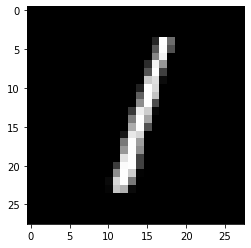

In [85]:
x, y = X_test[2], Y_test[2]
print ("This is an image of Number", y)
pixels = x.reshape((28,28))
plt.imshow(pixels,cmap="gray")

Check if the model is loaded correctly. The test accuracy may be 97.6%

In [86]:
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    #print(x, y)
    Y_pred[i] = clf.predict(x[None,:])
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest
print ("Test accuracy is", acc)

Test accuracy is 0.976


(d) **[2 points]** Please generate an adversarial example and check the image. 

This is an adversarial image of Number 7


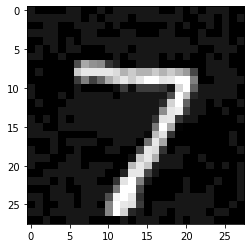

In [87]:
### Output pixels: the adversarial example. 
### YOUR CODE HERE
x, y = X_test[0], Y_test[0]
x_adv = clf.attack(x[None,:], y)
print ("This is an adversarial image of Number", y)
pixels = x_adv.reshape((28,28))
### END YOUR CODE
plt.imshow(pixels,cmap="gray")

(e) **[3 points]** Try the adversarial attack and test the accuracy of using adversarial examples.

You can get a test accuracy of using adversarial examples after running this cell.

In [88]:
### Output acc: the adversarial accuracy. 
### YOUR CODE HERE
nTest = 1000
Y_pred = np.zeros(nTest)
for i in range(nTest):
    x, y = X_test[i], Y_test[i]
    x_adv = clf.attack(x[None,:], y)
    Y_pred[i] = clf.predict(x_adv)
acc = np.sum(Y_pred == Y_test[:nTest])*1.0/nTest

### END YOUR CODE
print ("Test accuracy of adversarial examples is", acc)


Test accuracy of adversarial examples is 0.286
